# **💁🏻🗨️💁🏻‍♂️대화 요약 Baseline code**
> **Dialogue Summarization** 경진대회에 오신 여러분 환영합니다! 🎉    
> 본 대회에서는 최소 2명에서 최대 7명이 등장하여 나누는 대화를 요약하는 BART 기반 모델의 baseline code를 제공합니다.     
> 주어진 데이터를 활용하여 일상 대화에 대한 요약을 효과적으로 생성하는 모델을 만들어봅시다!

## ⚙️ 데이터 및 환경설정

### 1) 필요한 라이브러리 설치

- 필요한 라이브러리를 설치한 후 불러옵니다.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

# EDA 먼저 진행!


enc_lens 샘플 :  [322 284 215 191 196 360 199 204 157 164]


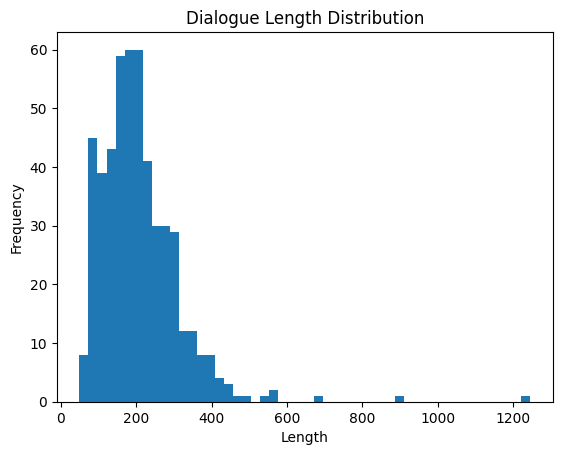


[Encoder(dialogue)] n=499
min / p50 / p90 / p95 / p98 / max = 50 / 192 / 317 / 374 / 450 / 1245

>>> Suggested encoder_max_len ≈ 529


In [82]:
# 1. 대화 최장 길이 확인

# 1) config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
config_path = "./config.yaml"
with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

data_path = loaded_config['general']['data_path']

# train_df = pd.read_csv(os.path.join(data_path,'train.csv'))
# train_df = pd.read_csv(os.path.join(data_path,'dev.csv'))
train_df = pd.read_csv(os.path.join(data_path,'test.csv'))

#  2) 토크나이저 준비
tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")

# 3) 대화 최장 길이 확인
enc = tokenizer(
    train_df["dialogue"].astype(str).tolist(),
    padding=False,
    truncation=False,              # 분포를 보려면 자르지 말고 순수 길이를 재야 함
    add_special_tokens=True,       # 실제 입력처럼 특수토큰 포함해서 길이 측정
    return_length=True
)

# dec = tokenizer(
#     train_df["summary"].astype(str).tolist(),
#     padding=False,
#     truncation=False,
#     add_special_tokens=True,
#     return_length=True
# )

enc_lens = np.array(enc["length"])   # 각 샘플의 encoder 토큰 길이
# dec_lens = np.array(dec["length"])   # 각 샘플의 decoder 토큰 길이

print("enc_lens 샘플 : ",enc_lens[:10])

# 대화 길이 분포 확인
lengths = enc["length"]
plt.hist(lengths, bins=50)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Dialogue Length Distribution")
plt.show()

# 4) 분포 요약
def describe(name, arr):
    print(f"\n[{name}] n={len(arr)}")
    print(f"min / p50 / p90 / p95 / p98 / max = "
          f"{arr.min()} / {np.percentile(arr,50):.0f} / {np.percentile(arr,90):.0f} / "
          f"{np.percentile(arr,95):.0f} / {np.percentile(arr,98):.0f} / {arr.max()}")

describe("Encoder(dialogue)", enc_lens)
# describe("Decoder(summary)", dec_lens)


# 5) 추천 값 (p95 기준, 안전 여유를 조금 더)
p = 99
enc_sug = int(np.percentile(enc_lens, p))
# dec_sug = int(np.percentile(dec_lens, p))

print(f"\n>>> Suggested encoder_max_len ≈ {enc_sug}")
# print(f">>> Suggested decoder_max_len ≈ {dec_sug}")

# 결과
# train 99% 커버 지점 : Suggested encoder_max_len ≈ 524 //  Suggested decoder_max_len ≈ 87
# dev 99% 커버 지점:  Suggested encoder_max_len ≈ 449 //  Suggested decoder_max_len ≈ 89
# test 99% 커버 지점: Suggested encoder_max_len ≈ 529

### 2) Config file 만들기 (선택)
- 모델 생성에 필요한 다양한 매개변수 정보를 저장할 수 있습니다.  
  따라서, 코드 상에서 모델의 매개변수를 설정할 수도 있지만 독립적인 매개변수 정보 파일을 생성하여 관리할 수 있습니다.

In [83]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")

In [84]:
# config_data = {
#     "general": {
#         "data_path": "/workspace/NLP_Dialogue_Summarization/data/", # 모델 생성에 필요한 데이터 경로를 사용자 환경에 맞게 지정합니다.
#         "model_name": "digit82/kobart-summarization", # 불러올 모델의 이름을 사용자 환경에 맞게 지정할 수 있습니다.
#         "output_dir": "/workspace/NLP_Dialogue_Summarization/output/submission" # 모델의 최종 출력 값을 저장할 경로를 설정합니다.
#     },
#     "tokenizer": {
#         "encoder_max_len": 529,
#         "decoder_max_len": 90,
#         "bos_token": f"{tokenizer.bos_token}",
#         "eos_token": f"{tokenizer.eos_token}",
#         # 특정 단어들이 분해되어 tokenization이 수행되지 않도록 special_tokens을 지정해줍니다.
#         "special_tokens": ['#Person1#', '#Person2#', '#Person3#', '#PhoneNumber#', '#Address#', '#PassportNumber#']
#     },
#     "training": {
#         "overwrite_output_dir": True,
#         "num_train_epochs": 20,
#         "learning_rate": 1e-5,
#         "per_device_train_batch_size": 50,
#         "per_device_eval_batch_size": 32,
#         "warmup_ratio": 0.1,
#         "weight_decay": 0.01,
#         "lr_scheduler_type": 'cosine',
#         "optim": 'adamw_torch',
#         "gradient_accumulation_steps": 1,
#         "evaluation_strategy": 'epoch',
#         "save_strategy": 'epoch',
#         "save_total_limit": 5,
#         "fp16": True,
#         "load_best_model_at_end": True,
#         "seed": 42,
#         "logging_dir": "./logs",
#         "logging_strategy": "epoch",
#         "predict_with_generate": True,
#         "generation_max_length": 100,
#         "do_train": True,
#         "do_eval": True,
#         "early_stopping_patience": 3,
#         "early_stopping_threshold": 0.001,
#         "report_to": "wandb" # (선택) wandb를 사용할 때 설정합니다.
#     },
#     # (선택) wandb 홈페이지에 가입하여 얻은 정보를 기반으로 작성합니다.
#     "wandb": {
#         "entity": "riicoseo-db",
#         "project": "nlp_dialogue_summarization",
#         "name": "test_run_12"
#     },
#     "inference": {
#         "ckt_path": "/workspace/NLP_Dialogue_Summarization/output/model", # 사전 학습이 진행된 모델의 checkpoint를 저장할 경로를 설정합니다.
#         "result_path": "/workspace/NLP_Dialogue_Summarization/output/prediction/",
#         "no_repeat_ngram_size": 2,
#         "early_stopping": True,
#         "generate_max_length": 100,
#         "num_beams": 4,
#         "batch_size" : 32,
#         # 정확한 모델 평가를 위해 제거할 불필요한 생성 토큰들을 정의합니다.
#         "remove_tokens": ['<usr>', f"{tokenizer.bos_token}", f"{tokenizer.eos_token}", f"{tokenizer.pad_token}"]
#     }
# }

- 참고✅    
: wandb 라이브러리를 사용하기 위해선 entity, project, name를 지정해주어야 합니다. wandb 홈페이지에 가입한 후 얻은 정보를 입력하여 작동할 수 있습니다.

In [85]:
# # 모델의 구성 정보를 YAML 파일로 저장합니다.
# config_path = "./config.yaml"
# with open(config_path, "w") as file:
#     yaml.dump(config_data, file, allow_unicode=True)

### 3) Configuration 불러오기

In [86]:
# 저장된 config 파일을 불러옵니다.
config_path = "./config.yaml"

with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

# 불러온 config 파일의 전체 내용을 확인합니다.
# pprint(loaded_config)

### 4) 데이터 불러와서 확인해보기
- 실험에서 쓰일 데이터를 load하여 데이터의 구조와 내용을 살펴보겠습니다.
- Train, dev, test 순서대로 12457, 499, 250개 씩 데이터가 구성되어 있습니다.

In [87]:
# config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
data_path = loaded_config['general']['data_path']

# train data의 구조와 내용을 확인합니다.
train_df = pd.read_csv(os.path.join(data_path,'train.csv'))
train_df.tail()

,fname,dialogue,summary,topic
12452,train_12455,#Person1#: 안녕하세요. 혹시 맨체스터에서 오신 Mr. Green 맞으신가요...,Tan Ling은 흰머리와 수염이 특징인 Mr. Green을 맞이하여 호텔로 안내합...,호텔 안내
12453,train_12456,"#Person1#: Mister Ewing이 우리 회의장에 4시에 오라고 했지, 맞...",#Person1#과 #Person2#는 Mister Ewing의 요청에 따라 회의장...,회의 준비
12454,train_12457,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,#Person2#는 #Person1#의 도움으로 5일 동안 소형차를 대여합니다.,차량 대여
12455,train_12458,#Person1#: 너 오늘 좀 기분 안 좋아 보인다? 무슨 일 있어?\n#Pers...,#Person2#의 어머니가 직장을 잃으셨다. #Person2#는 어머니가 우울해하...,실직과 대처
12456,train_12459,"#Person1#: 엄마, 나 다음 주 토요일에 이모부네 가족 보러 가는데, 오늘 ...",#Person1#은 다음 주 토요일에 이모부네 가족을 방문하기 위해 짐을 싸야 하는...,가족 방문 준비


In [88]:
# validation data의 구조와 내용을 확인합니다.
val_df = pd.read_csv(os.path.join(data_path,'dev.csv'))
val_df.tail()

,fname,dialogue,summary,topic
494,dev_495,#Person1#: 새해가 되니까 나도 새 출발을 하기로 했어.\n#Person2#...,#Person1#은 새해에 담배를 끊고 커밍아웃 하기로 결심했습니다. #Person...,새해 결심
495,dev_496,#Person1#: 너 Joe랑 결혼했지?\n#Person2#: Joe? 무슨 말이...,"#Person1#은 #Person2#가 Joe와 결혼했다고 생각하지만, #Perso...",사랑과 결혼 오해
496,dev_497,"#Person1#: 어떻게 도와드릴까요, 아줌마?\n#Person2#: 제 차에서 ...","#Person2#의 차에서 소리가 나며, 브레이크 수리가 필요한 상황입니다. #Pe...",차량 소음 및 수리
497,dev_498,"#Person1#: 여보세요, 아마존 고객 서비스입니다. 어떻게 도와드릴까요?\n#...",#Person2#가 아마존 고객 서비스에 전화하여 아마존에서 구매한 책에 53페이지...,책 페이지 누락
498,dev_499,#Person1#: 벌써 여름이 다가오다니 믿기지 않아. \n#Person2#: 맞...,"#Person2#는 여름방학 동안 파티에서 일하는 회사에서 일하며, 주로 음식 준비...",여름방학 일자리


## 1. 데이터 가공 및 데이터셋 클래스 구축
- csv file 을 불러와서 encoder 와 decoder의 입력형태로 가공해줍니다.
- 가공된 데이터를 torch dataset class 로 구축하여 모델에 입력가능한 형태로 만듭니다.

In [89]:
# 데이터 전처리를 위한 클래스로, 데이터셋을 데이터프레임으로 변환하고 인코더와 디코더의 입력을 생성합니다.
class Preprocess:
    def __init__(self,
            bos_token: str,
            eos_token: str,
        ) -> None:

        self.bos_token = bos_token
        self.eos_token = eos_token

    @staticmethod
    # 실험에 필요한 컬럼을 가져옵니다.
    def make_set_as_df(file_path, is_train = True):
        if is_train:
            df = pd.read_csv(file_path)
            train_df = df[['fname','dialogue','summary']]
            return train_df
        else:
            df = pd.read_csv(file_path)
            test_df = df[['fname','dialogue']]
            return test_df

    # BART 모델의 입력, 출력 형태를 맞추기 위해 전처리를 진행합니다.
    def make_input(self, dataset,is_test = False):
        if is_test:
            encoder_input = dataset['dialogue']
            decoder_input = [self.bos_token] * len(dataset['dialogue'])
            return encoder_input.tolist(), list(decoder_input)
        else:
            encoder_input = dataset['dialogue']
            decoder_input = dataset['summary'].apply(lambda x : self.bos_token + str(x)) # Ground truth를 디코더의 input으로 사용하여 학습합니다.
            decoder_output = dataset['summary'].apply(lambda x : str(x) + self.eos_token)
            return encoder_input.tolist(), decoder_input.tolist(), decoder_output.tolist()


In [90]:
# Train에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForTrain(Dataset):
    def __init__(self, encoder_input, decoder_input, labels, len):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.labels = labels
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()} # item[input_ids], item[attention_mask]
        item2 = {key: val[idx].clone().detach() for key, val in self.decoder_input.items()} # item2[input_ids], item2[attention_mask]
        item2['decoder_input_ids'] = item2['input_ids']
        item2['decoder_attention_mask'] = item2['attention_mask']
        item2.pop('input_ids')
        item2.pop('attention_mask')
        item.update(item2) #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask]
        item['labels'] = self.labels['input_ids'][idx] #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask], item[labels]
        return item

    def __len__(self):
        return self.len

# Validation에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForVal(Dataset):
    def __init__(self, encoder_input, decoder_input, labels, len):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.labels = labels
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()} # item[input_ids], item[attention_mask]
        item2 = {key: val[idx].clone().detach() for key, val in self.decoder_input.items()} # item2[input_ids], item2[attention_mask]
        item2['decoder_input_ids'] = item2['input_ids']
        item2['decoder_attention_mask'] = item2['attention_mask']
        item2.pop('input_ids')
        item2.pop('attention_mask')
        item.update(item2) #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask]
        item['labels'] = self.labels['input_ids'][idx] #item[input_ids], item[attention_mask] item[decoder_input_ids], item[decoder_attention_mask], item[labels]
        return item

    def __len__(self):
        return self.len

# Test에 사용되는 Dataset 클래스를 정의합니다.
class DatasetForInference(Dataset):
    def __init__(self, encoder_input, test_id, len):
        self.encoder_input = encoder_input
        self.test_id = test_id
        self.len = len

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encoder_input.items()}
        item['ID'] = self.test_id[idx]
        return item

    def __len__(self):
        return self.len


In [91]:
# tokenization 과정까지 진행된 최종적으로 모델에 입력될 데이터를 출력합니다.
def prepare_train_dataset(config, preprocessor, data_path, tokenizer):
    train_file_path = os.path.join(data_path,'train.csv')
    val_file_path = os.path.join(data_path,'dev.csv')

    # train, validation에 대해 각각 데이터프레임을 구축합니다.
    train_data = preprocessor.make_set_as_df(train_file_path)
    val_data = preprocessor.make_set_as_df(val_file_path)

    print('-'*150)
    print(f'train_data:\n {train_data["dialogue"][0]}')
    print(f'train_label:\n {train_data["summary"][0]}')

    print('-'*150)
    print(f'val_data:\n {val_data["dialogue"][0]}')
    print(f'val_label:\n {val_data["summary"][0]}')

    encoder_input_train , decoder_input_train, decoder_output_train = preprocessor.make_input(train_data)
    encoder_input_val , decoder_input_val, decoder_output_val = preprocessor.make_input(val_data)
    print('-'*10, 'Load data complete', '-'*10,)

    tokenized_encoder_inputs = tokenizer(encoder_input_train, return_tensors="pt", padding=True,
                            add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False)
    tokenized_decoder_inputs = tokenizer(decoder_input_train, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)
    tokenized_decoder_ouputs = tokenizer(decoder_output_train, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)

    train_inputs_dataset = DatasetForTrain(tokenized_encoder_inputs, tokenized_decoder_inputs, tokenized_decoder_ouputs,len(encoder_input_train))

    val_tokenized_encoder_inputs = tokenizer(encoder_input_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False)
    val_tokenized_decoder_inputs = tokenizer(decoder_input_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)
    val_tokenized_decoder_ouputs = tokenizer(decoder_output_val, return_tensors="pt", padding=True,
                        add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False)

    val_inputs_dataset = DatasetForVal(val_tokenized_encoder_inputs, val_tokenized_decoder_inputs, val_tokenized_decoder_ouputs,len(encoder_input_val))

    print('-'*10, 'Make dataset complete', '-'*10,)
    return train_inputs_dataset, val_inputs_dataset

## 2. Trainer 및 Trainingargs 구축하기
- Huggingface 의 Trainer 와 Training arguments를 활용하여 모델 학습을 일괄적으로 처리해주는 클래스를 정의합니다.

In [92]:
# 모델 성능에 대한 평가 지표를 정의합니다. 본 대회에서는 ROUGE 점수를 통해 모델의 성능을 평가합니다.
def compute_metrics(config,tokenizer,pred):
    rouge = Rouge()
    predictions = pred.predictions
    labels = pred.label_ids

    predictions[predictions == -100] = tokenizer.pad_token_id
    labels[labels == -100] = tokenizer.pad_token_id

    decoded_preds = tokenizer.batch_decode(predictions, clean_up_tokenization_spaces=True)
    labels = tokenizer.batch_decode(labels, clean_up_tokenization_spaces=True)

    # 정확한 평가를 위해 미리 정의된 불필요한 생성토큰들을 제거합니다.
    replaced_predictions = decoded_preds.copy()
    replaced_labels = labels.copy()
    remove_tokens = config['inference']['remove_tokens']
    for token in remove_tokens:
        replaced_predictions = [sentence.replace(token," ") for sentence in replaced_predictions]
        replaced_labels = [sentence.replace(token," ") for sentence in replaced_labels]

    print('-'*150)
    print(f"PRED: {replaced_predictions[0]}")
    print(f"GOLD: {replaced_labels[0]}")
    print('-'*150)
    print(f"PRED: {replaced_predictions[1]}")
    print(f"GOLD: {replaced_labels[1]}")
    print('-'*150)
    print(f"PRED: {replaced_predictions[2]}")
    print(f"GOLD: {replaced_labels[2]}")

    # 최종적인 ROUGE 점수를 계산합니다.
    results = rouge.get_scores(replaced_predictions, replaced_labels,avg=True)

    # ROUGE 점수 중 F-1 score를 통해 평가합니다.
    result = {key: value["f"] for key, value in results.items()}
    return result

In [97]:
# 학습을 위한 trainer 클래스와 매개변수를 정의합니다.
def load_trainer_for_train(config,generate_model,tokenizer,train_inputs_dataset,val_inputs_dataset):
    print('-'*10, 'Make training arguments', '-'*10,)
    # set training args
    training_args = Seq2SeqTrainingArguments(
                output_dir=config['general']['output_dir'], # model output directory
                overwrite_output_dir=config['training']['overwrite_output_dir'],
                num_train_epochs=config['training']['num_train_epochs'],  # total number of training epochs
                learning_rate=config['training']['learning_rate'], # learning_rate
                per_device_train_batch_size=config['training']['per_device_train_batch_size'], # batch size per device during training
                per_device_eval_batch_size=config['training']['per_device_eval_batch_size'],# batch size for evaluation
                warmup_ratio=config['training']['warmup_ratio'],  # number of warmup steps for learning rate scheduler
                weight_decay=config['training']['weight_decay'],  # strength of weight decay
                lr_scheduler_type=config['training']['lr_scheduler_type'],
                optim =config['training']['optim'],
                gradient_accumulation_steps=config['training']['gradient_accumulation_steps'],
                eval_strategy=config['training']['evaluation_strategy'], # evaluation strategy to adopt during training
                save_strategy =config['training']['save_strategy'],
                save_total_limit=config['training']['save_total_limit'], # number of total save model.
                fp16=config['training']['fp16'],
                load_best_model_at_end=config['training']['load_best_model_at_end'], # 최종적으로 가장 높은 점수 저장
                seed=config['training']['seed'],
                logging_dir=config['training']['logging_dir'], # directory for storing logs
                logging_strategy=config['training']['logging_strategy'],
                predict_with_generate=config['training']['predict_with_generate'], #To use BLEU or ROUGE score
                generation_max_length=config['training']['generation_max_length'],
                do_train=config['training']['do_train'],
                do_eval=config['training']['do_eval'],
                metric_for_best_model="rouge-l",
                greater_is_better=True,  
                report_to=[],
                # report_to=config['training']['report_to'], # (선택) wandb를 사용할 때 설정합니다.
            )

    # (선택) 모델의 학습 과정을 추적하는 wandb를 사용하기 위해 초기화 해줍니다.
    # wandb.init(
    #     entity=config['wandb']['entity'],
    #     project=config['wandb']['project'],
    #     name=config['wandb']['name'],
    #     settings=wandb.Settings(start_method="thread", init_timeout=300)
    # )

    # # (선택) 모델 checkpoint를 wandb에 저장하도록 환경 변수를 설정합니다.
    # os.environ["WANDB_LOG_MODEL"]="false"
    # os.environ["WANDB_WATCH"]="false"

    # Validation loss가 더 이상 개선되지 않을 때 학습을 중단시키는 EarlyStopping 기능을 사용합니다.
    MyCallback = EarlyStoppingCallback(
        early_stopping_patience=config['training']['early_stopping_patience'],
        early_stopping_threshold=config['training']['early_stopping_threshold']
    )
    print('-'*10, 'Make training arguments complete', '-'*10,)
    print('-'*10, 'Make trainer', '-'*10,)

    # Trainer 클래스를 정의합니다.
    trainer = Seq2SeqTrainer(
        model=generate_model, # 사용자가 사전 학습하기 위해 사용할 모델을 입력합니다.
        args=training_args,
        train_dataset=train_inputs_dataset,
        eval_dataset=val_inputs_dataset,
        compute_metrics = lambda pred: compute_metrics(config,tokenizer, pred),
        callbacks = [MyCallback]
    )
    print('-'*10, 'Make trainer complete', '-'*10,)

    return trainer

In [94]:
# 학습을 위한 tokenizer와 사전 학습된 모델을 불러옵니다.
def load_tokenizer_and_model_for_train(config,device):
    print('-'*10, 'Load tokenizer & model', '-'*10,)
    print('-'*10, f'Model Name : {config["general"]["model_name"]}', '-'*10,)
    model_name = config['general']['model_name']
    bart_config = BartConfig().from_pretrained(model_name)
    bart_config.tie_word_embeddings = True
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    generate_model = BartForConditionalGeneration.from_pretrained(config['general']['model_name'],config=bart_config)

    special_tokens_dict={'additional_special_tokens':config['tokenizer']['special_tokens']}
    tokenizer.add_special_tokens(special_tokens_dict)

    generate_model.resize_token_embeddings(len(tokenizer)) # 사전에 special token을 추가했으므로 재구성 해줍니다.
    generate_model.to(device)
    # print(generate_model.config)

    print('-'*10, 'Load tokenizer & model complete', '-'*10,)
    return generate_model , tokenizer

## 3. 모델 학습하기

- 앞에서 구축한 클래스 및 함수를 활용하여 학습 진행합니다.

In [95]:
def main(config):
    # 사용할 device를 정의합니다.
    device = torch.device('cuda:0' if torch.cuda.is_available()  else 'cpu')
    print('-'*10, f'device : {device}', '-'*10,)
    print(torch.__version__)

    # 사용할 모델과 tokenizer를 불러옵니다.
    generate_model , tokenizer = load_tokenizer_and_model_for_train(config,device)
    print('-'*10,"tokenizer special tokens : ",tokenizer.special_tokens_map,'-'*10)

    # 학습에 사용할 데이터셋을 불러옵니다.
    preprocessor = Preprocess(config['tokenizer']['bos_token'], config['tokenizer']['eos_token']) # decoder_start_token: str, eos_token: str
    data_path = config['general']['data_path']
    train_inputs_dataset, val_inputs_dataset = prepare_train_dataset(config,preprocessor, data_path, tokenizer)

    # Trainer 클래스를 불러옵니다.
    trainer = load_trainer_for_train(config, generate_model,tokenizer,train_inputs_dataset,val_inputs_dataset)
    trainer.train()   # 모델 학습을 시작합니다.

    # (선택) 모델 학습이 완료된 후 wandb를 종료합니다.
    # wandb.finish()

In [98]:
if __name__ == "__main__":
    main(loaded_config)

---------- device : cuda:0 ----------
2.8.0+cu128
---------- Load tokenizer & model ----------
---------- Model Name : digit82/kobart-summarization ----------


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


---------- Load tokenizer & model complete ----------
---------- tokenizer special tokens :  {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>', 'additional_special_tokens': ['#Person1#', '#Person2#', '#Person3#', '#PhoneNumber#', '#Address#', '#PassportNumber#']} ----------
------------------------------------------------------------------------------------------------------------------------------------------------------
train_data:
 #Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다. 오늘 무슨 일로 오셨어요? 
#Person2#: 건강검진을 받으려고 왔어요. 
#Person1#: 네, 5년 동안 검진을 안 받으셨네요. 매년 한 번씩 받으셔야 해요. 
#Person2#: 알죠. 특별히 아픈 데가 없으면 굳이 갈 필요가 없다고 생각했어요. 
#Person1#: 음, 심각한 질병을 피하려면 미리 발견하는 게 제일 좋거든요. 본인을 위해서라도 매년 한 번은 오세요. 
#Person2#: 알겠습니다. 
#Person1#: 여기 좀 볼까요. 눈과 귀는 괜찮으시네요. 깊게 숨 한 번 쉬어보세요. Mr. Smith, 담배 피우세요? 
#Person2#: 네. 
#Person1#: 담배가 폐암하고 심장병의 주된 원인인 거 아시죠? 끊으셔야 해요. 
#Person2#: 수백 번 시도했는데, 도저히 습관이 안 끊어져요. 
#Person1#: 음, 도움 될만한 수업과 약물들이 있습니다. 가시기 전에 더

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


---------- Make dataset complete ----------
---------- Make training arguments ----------
---------- Make training arguments complete ----------
---------- Make trainer ----------
---------- Make trainer complete ----------


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,5.386100,2.676273,0.164038,0.026102,0.159146
2,1.503300,0.787880,0.241124,0.043873,0.233649
3,0.694800,0.605328,0.340564,0.109949,0.321199
4,0.594200,0.588205,0.358056,0.124805,0.338401
5,0.553900,0.580221,0.361803,0.129006,0.342372
6,0.524200,0.575458,0.360739,0.131674,0.342574
7,0.498000,0.573416,0.362868,0.132467,0.341301
8,0.478600,0.575430,0.356625,0.126152,0.335469
9,0.460700,0.574104,0.365961,0.131865,0.344825
10,0.445300,0.577567,0.367235,0.134977,0.346135


------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:   웸터리는 천식 검사를 위해 폐 전문의에게 천식 검사를 의뢰합니다.                                                                                  
GOLD: #Person2# 는 숨쉬기 어려워합니다. 의사는 #Person2# 에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.                                                            
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:   야 Jimmy와 린이 에게  농구하고 복근 운동하자고 제안합니다.                                                                                
GOLD: #Person1# 는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.                                                                       
------------------------------------------------------------------------------------------------------------------------------------------------------
PRED:    니는 과일이랑 채소, 

## 4. 모델 추론하기

In [104]:
# 이곳에 내가 사용할 wandb config 설정
loaded_config['inference']['ckt_path'] = "/workspace/NLP_Dialogue_Summarization/output/submission/checkpoint-4750"

- test data를 사용하여 모델의 성능을 확인합니다.

In [100]:
# tokenization 과정까지 진행된 최종적으로 모델에 입력될 데이터를 출력합니다.
def prepare_test_dataset(config,preprocessor, tokenizer):

    test_file_path = os.path.join(config['general']['data_path'],'test.csv')

    test_data = preprocessor.make_set_as_df(test_file_path,is_train=False)
    test_id = test_data['fname']

    print('-'*150)
    print(f'test_data:\n{test_data["dialogue"][0]}')
    print('-'*150)

    encoder_input_test , decoder_input_test = preprocessor.make_input(test_data,is_test=True)
    print('-'*10, 'Load data complete', '-'*10,)

    test_tokenized_encoder_inputs = tokenizer(encoder_input_test, return_tensors="pt", padding=True,
                    add_special_tokens=True, truncation=True, max_length=config['tokenizer']['encoder_max_len'], return_token_type_ids=False,)
    test_tokenized_decoder_inputs = tokenizer(decoder_input_test, return_tensors="pt", padding=True,
                    add_special_tokens=True, truncation=True, max_length=config['tokenizer']['decoder_max_len'], return_token_type_ids=False,)

    test_encoder_inputs_dataset = DatasetForInference(test_tokenized_encoder_inputs, test_id, len(encoder_input_test))
    print('-'*10, 'Make dataset complete', '-'*10,)

    return test_data, test_encoder_inputs_dataset

In [101]:
# 추론을 위한 tokenizer와 학습시킨 모델을 불러옵니다.
def load_tokenizer_and_model_for_test(config,device):
    print('-'*10, 'Load tokenizer & model', '-'*10,)

    model_name = config['general']['model_name']
    ckt_path = config['inference']['ckt_path']
    print('-'*10, f'Model Name : {model_name}', '-'*10,)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    special_tokens_dict = {'additional_special_tokens': config['tokenizer']['special_tokens']}
    tokenizer.add_special_tokens(special_tokens_dict)

    generate_model = BartForConditionalGeneration.from_pretrained(ckt_path)
    generate_model.resize_token_embeddings(len(tokenizer))
    generate_model.to(device)
    print('-'*10, 'Load tokenizer & model complete', '-'*10,)

    return generate_model , tokenizer

In [102]:
# 학습된 모델이 생성한 요약문의 출력 결과를 보여줍니다.
def inference(config):
    device = torch.device('cuda:0' if torch.cuda.is_available()  else 'cpu')
    print('-'*10, f'device : {device}', '-'*10,)
    print(torch.__version__)

    generate_model , tokenizer = load_tokenizer_and_model_for_test(config,device)

    data_path = config['general']['data_path']
    preprocessor = Preprocess(config['tokenizer']['bos_token'], config['tokenizer']['eos_token'])

    test_data, test_encoder_inputs_dataset = prepare_test_dataset(config,preprocessor, tokenizer)
    dataloader = DataLoader(test_encoder_inputs_dataset, batch_size=config['inference']['batch_size'])

    summary = []
    text_ids = []
    with torch.no_grad():
        for item in tqdm(dataloader):
            text_ids.extend(item['ID'])
            generated_ids = generate_model.generate(input_ids=item['input_ids'].to('cuda:0'),
                            no_repeat_ngram_size=config['inference']['no_repeat_ngram_size'],
                            early_stopping=config['inference']['early_stopping'],
                            max_length=config['inference']['generate_max_length'],
                            num_beams=config['inference']['num_beams'],
                        )
            for ids in generated_ids:
                result = tokenizer.decode(ids)
                summary.append(result)

    # 정확한 평가를 위하여 노이즈에 해당되는 스페셜 토큰을 제거합니다.
    remove_tokens = config['inference']['remove_tokens']
    preprocessed_summary = summary.copy()
    for token in remove_tokens:
        preprocessed_summary = [sentence.replace(token," ") for sentence in preprocessed_summary]

    output = pd.DataFrame(
        {
            "fname": test_data['fname'],
            "summary" : preprocessed_summary,
        }
    )
    result_path = config['inference']['result_path']
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    output.to_csv(os.path.join(result_path, "output.csv"), index=False)

    return output

In [105]:
# 학습된 모델의 test를 진행합니다.
if __name__ == "__main__":
    output = inference(loaded_config)

---------- device : cuda:0 ----------
2.8.0+cu128
---------- Load tokenizer & model ----------
---------- Model Name : digit82/kobart-summarization ----------


You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


---------- Load tokenizer & model complete ----------
------------------------------------------------------------------------------------------------------------------------------------------------------
test_data:
#Person1#: Ms. Dawson, 받아쓰기 좀 부탁드려야겠어요. 
#Person2#: 네, 말씀하세요... 
#Person1#: 이걸 오늘 오후까지 모든 직원들에게 사내 메모로 보내야 해요. 준비됐나요? 
#Person2#: 네, 말씀하세요. 
#Person1#: 모든 직원에게 알립니다... 즉시 발효되어 모든 사내 통신은 이메일과 공식 메모로만 제한됩니다. 근무 시간 동안 즉시 메시지 프로그램 사용은 금지됩니다. 
#Person2#: 이 정책이 사내 통신에만 적용되나요, 아니면 외부 통신에도 해당되나요? 
#Person1#: 이는 모든 통신에 적용됩니다. 사무실 내 직원 간 통신 뿐만 아니라 외부 통신도 해당됩니다. 
#Person2#: 하지만 많은 직원들이 고객과 소통하려고 즉시 메시지를 사용합니다. 
#Person1#: 통신 방법을 바꿔야 할 것입니다. 이 사무실에서는 즉시 메시지를 사용하는 것을 원하지 않습니다. 너무 많은 시간이 낭비됩니다! 이제 계속해서 메모를 작성해 주세요. 어디까지 했죠? 
#Person2#: 내외부 통신에 적용됩니다. 
#Person1#: 네. 즉시 메시지를 계속 사용하면 경고 후 시정 조치가 이루어지며, 두 번째 위반 시 해고될 수 있습니다. 이번 정책에 관한 질문은 부서장에게 문의하세요. 
#Person2#: 그게 다인가요? 
#Person1#: 네. 오늘 오후 4시까지 이 메모를 작성하고 배포해주세요.
----------------------------------------------------------------------------

100%|██████████| 16/16 [00:38<00:00,  2.38s/it]


In [ ]:
output  # 각 대화문에 대한 요약문이 출력됨을 확인할 수 있습니다.

,fname,summary
0,test_0,#Person1# 은 Ms. Dawson에게 이메일과 공식 메모로만 제한되는 사내...
1,test_1,#Person1# 과 #Person2# 는 교통체증으로 인해 출퇴근에 어려움을 겪...
2,test_2,Kate는 #Person1# 에게 Masha와 Hero가 이혼했다고 말합니다. ...
3,test_3,"#Person1# 은 Brian에게 생일 선물로 목걸이를 주며, 생일 파티에서 함..."
4,test_4,#Person1# 과 #Person2# 는 올림픽 공원의 크기와 시설에 대해 이야...
...,...,...
494,test_495,"Charlie와 Jack은 학교 후 비디오 게임을 하기로 결정하고, Cohen은..."
495,test_496,#Person1# 은 #Person2# 에게 시골 음악에 관심을 갖게 된 계기와 ...
496,test_497,Alice는 #Person1# 에게 세탁기 사용법을 설명합니다. 세탁기는 비누가...
497,test_498,Steve는 Matthew에게 임대를 갱신하고 싶지 않아 집을 찾고 있다고 말하...


: 